In [1]:
import torch
import os, random
import torch.nn.functional as F

random.seed(0)


def get_random_folder(directory):
    # Get a list of all entries in the directory
    entries = os.listdir(directory)
    # Filter out files, keeping only directories
    folders = [
        entry for entry in entries if os.path.isdir(os.path.join(directory, entry))
    ]

    if not folders:
        return None  # If there are no folders, return None

    # Randomly select a folder
    random_folder = random.choice(folders)
    return os.path.join(directory, random_folder) + "/"


def test(d):
    x = torch.load(d + "x.pth").reshape(1, -1)
    o3 = torch.load(d + "o3.pth").reshape(1, -1)
    w1 = torch.load(d + "w1.pth")
    w2 = torch.load(d + "w2.pth")
    w3 = torch.load(d + "w3.pth")
    print(x.shape, o3.shape, w1.shape, w2.shape, w3.shape)

    def prune_zeros(x):
        output = x.clone()
        abs_x = torch.abs(x)
        med_value, med_indices = torch.median(abs_x, dim=-1)
        # logger.warning(f"med {med_value} mean {torch.mean(abs_x)}")
        output[abs_x < med_value.item()] = 0
        # print("zeros", (output == 0).sum())
        return output

    def prune_zeros_opt(x, w):
        val = torch.norm(w, p=2, dim=0)
        output = x.clone()
        abs_x = torch.abs(x)
        med_value, med_indices = torch.median(abs_x * val, dim=-1)
        # logger.warning(f"med {med_value} mean {torch.mean(abs_x)}")
        output[abs_x * val < med_value.item()] = 0
        # print("zeros", (output == 0).sum())
        return output

    orig = F.silu(torch.mm(x, w1.t())).squeeze()
    simi = F.silu(torch.mm(prune_zeros(x), w1.t())).squeeze()
    simi2 = F.silu(torch.mm(prune_zeros_opt(x, w1), w1.t())).squeeze()
    print("cos1", end=" ")
    print(
        F.cosine_similarity(orig, simi, dim=0).item(), (orig.sum() / simi.sum()).item()
    )
    print(
        F.cosine_similarity(orig, simi2, dim=0).item(),
        (orig.sum() / simi2.sum()).item(),
    )

    orig = (torch.mm(x, w3.t())).squeeze()
    simi = (torch.mm(prune_zeros(x), w3.t())).squeeze()
    simi2 = (torch.mm(prune_zeros_opt(x, w3), w3.t())).squeeze()
    print("cos2", end=" ")
    print(
        F.cosine_similarity(orig, simi, dim=0).item(), (orig.sum() / simi.sum()).item()
    )
    print(
        F.cosine_similarity(orig, simi2, dim=0).item(),
        (orig.sum() / simi2.sum()).item(),
    )

    orig = (torch.mm(o3, w2.t())).squeeze()
    simi = (torch.mm(prune_zeros(o3), w2.t())).squeeze()
    print("cos3", end=" ")
    print(
        F.cosine_similarity(orig, simi, dim=0).item(), (orig.sum() / simi.sum()).item()
    )

    px = prune_zeros(x)
    orig = torch.mm(F.silu(torch.mm(x, w1.t())) * torch.mm(x, w3.t()), w2.t()).squeeze()
    simi = torch.mm(
        prune_zeros(F.silu(torch.mm(px, w1.t())) * torch.mm(px, w3.t())), w2.t()
    ).squeeze()
    print("cos4", end=" ")
    print(
        F.cosine_similarity(orig, simi, dim=0).item(), (orig.sum() / simi.sum()).item()
    )

    px = prune_zeros(x)
    orig = torch.mm(F.silu(torch.mm(x, w1.t())) * torch.mm(x, w3.t()), w2.t()).squeeze()
    simi = torch.mm(
        (F.silu(torch.mm(px, w1.t())) * torch.mm(px, w3.t())), w2.t()
    ).squeeze()
    print("cos5", end=" ")
    print(
        F.cosine_similarity(orig, simi, dim=0).item(), (orig.sum() / simi.sum()).item()
    )




../dumps/2024-06-25_15-32-42_1719300762.6169834/
../dumps/2024-06-25_15-33-50_1719300830.8963938/
../dumps/2024-06-25_15-33-27_1719300807.9494612/
../dumps/2024-06-25_15-34-20_1719300860.2731524/
../dumps/2024-06-25_15-32-07_1719300727.0824575/


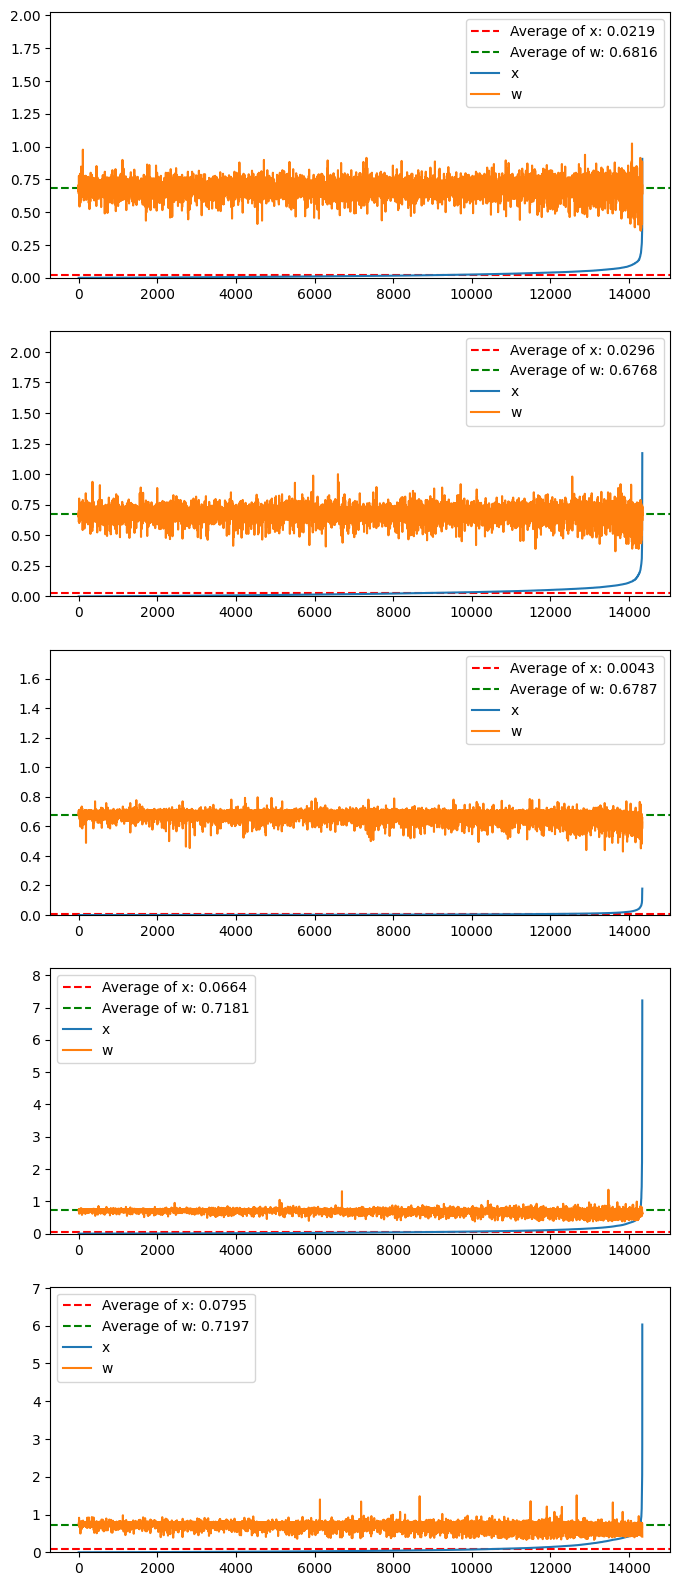

In [2]:

import matplotlib.pyplot as plt
def plot():
    num = 5
    fig, axs = plt.subplots(num, 1, figsize=(8, 20))
    for i in range(num):
        d = get_random_folder("../dumps")
        print(d)
        x = torch.load(d + "o3.pth").view(-1)
        # x = x.float().cpu().numpy()
        x = x.float().abs().cpu().numpy()
        w = torch.load(d + "w2.pth")
        w = torch.norm(w, p=2, dim=0).reshape(-1)
        w = w.float().abs().cpu().numpy()
        # sort x
        sort_x = x.argsort()
        x = x[sort_x]
        w = w[sort_x]

        axs[i].set_ylim(min(min(x), 0), max(max(x), max(w)) + 1)
        axs[i].axhline(x.mean(), color='r', linestyle='--', label=f'Average of x: {x.mean():.4f}')
        axs[i].axhline(w.mean(), color='g', linestyle='--', label=f'Average of w: {w.mean():.4f}')
        axs[i].plot(x, label="x")
        axs[i].plot(w, label="w")
        axs[i].legend()
        # plt.show()
plot()